In [1]:
import underworld as uw
import warnings
from matplotlib.figure import Figure
import matplotlib.pyplot as pyplot
import numpy as np
import math
#import glucifer
#import mpi4py
#comm = mpi4py.MPI.COMM_WORLD
import h5py
import glob
import UWGeodynamics as GEO
from MechanicalProperties import PlateProperties
from pathlib import Path
import sys
import underworld.function as fn
import lavavu

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [11]:
def getColoursfromMap(cmapKey,NumColours):
    cmap = plt.get_cmap(cmapKey)
    norm = mcolors.Normalize(vmin=1.5, vmax=NumColours)
    #Base array to calculate the colors
    seedColors=np.arange(0,NumColours,1) #Here is the start color
    colours=cmap(norm(seedColors))
    return colours

def genStdColorArray(Thicknesses,colors,colorflip):
    iColor=0
    limitThick=colorflip[1]
    plotCounter=0
    #Get Colors and put them into an array
    ColorsS=[]
    colorC=0
    for j in colors:
        ColorsS.append(getColoursfromMap(colors[colorC],len(Thicknesses)))
        colorC=colorC+1
    counter=0
    #array which will contain colors to return    
    FinalColours=[]
    
    for i in Thicknesses:
        #Color changes
        if colorflip[0]==True:
            if limitThick> i:
                Colors=ColorsS[0]
            elif limitThick<=i:
                Colors=ColorsS[1]    
            else:
                Colors=ColorsS[0]     
        color=Colors[counter]
        FinalColours.append(color)
        counter=counter+1
    return FinalColours

def SlabDipLoader(DataDir,thickness,depth,layer,fileSeed):
    fileName=DataDir+fileSeed+"{0}_{1}km_depth_layer-{2}.txt".format(str(thickness),str(abs(depth)),str(layer))
    Data = np.genfromtxt(fileName, dtype=float)
    t,dip=Data[:,0],Data[:,1]
    return t,dip

def velocitiesLoader(DataDir,thickness,typePlot,fileSeed):
    fileName=DataDir+fileSeed+"{0}.txt".format(str(thickness))
    Data = np.genfromtxt(fileName, dtype=float,skip_footer=1)
    v_sp=Data[:,1]
    v_op=-Data[:,3]
    v_t=-(Data[:,2]+Data[:,3])
    #v_t2=-Data[:,4]
    #Independent from reference frame
    Vc=v_op+v_sp
    Vs=v_t+v_sp
    
    if typePlot=="subduction_velocity":
        t,vel=Data[:,0],v_sp
    elif typePlot=="Trench_retreat_vel":
        t,vel=Data[:,0],v_t
    elif typePlot=="OP_retreat_vel":
        t,vel=Data[:,0],v_op
    elif typePlot=="Arc_retreat_vel":
        t,vel=Data[:,0],v_t2
    elif typePlot=="OPDefRate": #overriding plate deformation rate
        t,vel=Data[:,0],v_t-v_op
    elif typePlot=="Sub_vel": #Actual subduction velocity?
        t,vel=Data[:,0],v_t+v_sp
    elif typePlot=="Conver_vel":
        t,vel=Data[:,0], v_sp+v_op
    return t,vel

In [62]:
from matplotlib.ticker import ScalarFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.offsetbox import AnchoredText

def filterTimes(t,var,filTime):
    times=[]
    dat=[]
    k=0
    for i,j in zip (t,var):
        if i>= filTime:
            break
        else:
            times.append(i)  #Assign X-coordinate - Horizontal distance
            dat.append(j)  #Asign Y-Coordinate -StressY delta
        k=k+1
    
    return times,dat

#def stepsGenerator(start,end,step):--SEEEE
def plotDipKinematicsAll(thicknesses,depthCuts,layer,filterTime,Colors,figsize):
    from matplotlib.offsetbox import AnchoredText
#Time_array,SPVel,OPVel,arcVel,cratVel,Xlabel,figsize,Thicknesses,thicknessLabel,Colors

    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    #PLots to include in the subplots
    #Nplots=2
    #areaTypes=["Lithosphere","whole"]#,"Mantle"]
    #labelTitles=["Lithosphere","Whole domain","Asthenosphere"]
    labelTitles=["80km depth","300km depth"]
    #plotTypes=["80","300"]
    
    #if filterTime: in buoyant arcs after a certain time dip angle is not ploted as the subduction zone stops
    
    markers=["","",""]
    #markers=["v","+","^"]
    lineStyles=["-","-"]
    #Figure parameters
    fig, axs = pyplot.subplots(len(depthCuts)+1,2,figsize=figsize,sharex=True)
    Max=0
    Min=0
    #ax=axs[1]
    inde=[0,1]
    #ax1=axs[2]
    plotCounter=0
    for j in depthCuts:
        #print(j)
        for k in inde: #repeats the dip plot for comparing with multiple types of velocity
            #print(np.size(axs))
            #print(k,plotCounter)
            seed=axs[plotCounter+1][k]
            counter=0
            #print(counter)
            for i in thicknesses:
                #print(i)
                #dipData=SlabDipLoader('/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Slab_dipData/',j,cutDepth,layer,"SPdip_")
                t,slabDips=SlabDipLoader('/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Slab_dipData/',i,int(j),layer,"SPdip_")
                if filterTime!=False and int(i)>31:
                    t,slabDips=filterTimes(t,slabDips,filterTime)
                #t=dipData[0]
                #slabDips=dipData[1]   
                #t,intVDiss=loadViscousDissTime_Thicknesses("/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Viscous_dissipation_data/",i,"ViscousDissipation_",j)
                #plot parameters
                seed.set_ylabel("Slab dip (°)",labelpad=2,fontsize=8)
                if i==0:
                    colour='black'
                else:
                    colour=Colors[counter]
                #plot data
                line1,=seed.plot(t,slabDips,linewidth=0.7,color=colour,marker=markers[plotCounter],
                          markersize=3.0,markevery=5,linestyle=lineStyles[plotCounter])
                seed.set_xlim(0,50)
                seed.tick_params(axis = 'both', which = 'major', labelsize = 8)
                Max=max(slabDips)
                Min=min(slabDips)
                counter=counter+1
            seed.set_xlabel("Time (Ma)",labelpad=2,fontsize=8)
            if j>-100:
                seed.set_ylim(min(slabDips)-min(slabDips)*1/2,max(slabDips)+1/10*max(slabDips))
            else:
                seed.set_ylim(min(slabDips),max(slabDips)+1/8*max(slabDips))
            #seed.set_ylim(0,Max+Max*1/6)
            seed.axvline(x=16,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
            seed.axvline(x=22.5,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
            seed.axvline(x=34,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
            adjustX=(0+45)/9.
            arrangeTicksX=np.arange(0,46,adjustX)
            seed.xaxis.set_ticks(arrangeTicksX)
        plotCounter=plotCounter+1

    #Velocity axis settings
    #typePlots=["subduction_velocity","Trench_retreat_vel","OP_retreat_vel","Arc_retreat_vel"]
    #names=["Subducting plate","Trench-retreat velocity vs Time","OP retreat velocity vs Time","Arc retreat velocity vs Time"]
    
    typePlots=["OPDefRate","Sub_vel","Conver_vel","Arc_retreat_vel"]
    names=["OP deformation rate","Subduction velocity","Convergence velocity","Arc retreat velocity vs Time"]
    
    plotsType=[typePlots[1],typePlots[0]]
    #print(plotsType)
    
    
    #Loop for iterating thicknesses
    plotCounter=0
    for j in plotsType:
        counter=0
        Max=0
        Min=0
        for i in thicknesses:
            #print(plotCounter)
            seed=axs[0][plotCounter]
            #plotType=typePlots[0]
            #Have to replace this line for the loading function..
            t,vel=velocitiesLoader('/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Kinematics_data/',i,j,"platesVelocities_")
            if i==0:
                colour='black'
            else:
                colour=Colors[counter]
            seed.plot(t,vel,label='{0} Km'.format((eval(str(i)))),linewidth=0.7,color=colour)
            seed.set_ylabel("Velocity (cm/yr)",labelpad=2,fontsize=8)
            #seed.legend(fontsize=int(8.5),fancybox=True)
            seed.tick_params(axis = 'both', which = 'major', labelsize =8) 
            seed.set_xlim(0,45)
            
            #seed.yaxis.set_major_locator(mpl.ticker.LinearLocator(5))
            Max=max(vel)
            Min=min(vel)
            seed.set_ylim((1.52*Min),Max*1.78) #1.98
            if j=="OPDefRate":
                seed.set_ylabel(r"$V_{OPD}$"+" (cm/yr)",labelpad=2,fontsize=8)
                #pyplot.yscale('symlog')
                seed.set_ylim((1.22*Min),Max*2.58)
                a=1
            elif j=="Sub_vel":
                seed.set_ylabel(r"$V_{S}$"+" (cm/yr)",labelpad=2,fontsize=8)
         
            counter=counter+1

        #counter=counter-1
        seed.set_xlabel("Time (Ma)",labelpad=2,fontsize=8)
        seed.axhline(y=0, xmin=0, xmax=max(t)+max(t)/6.,color='black',linestyle='--',linewidth=0.7,alpha=0.4)
        seed.axvline(x=16,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
        seed.axvline(x=22.5,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)
        seed.axvline(x=34,ymin=-10,ymax=10,linestyle='--',color='black',linewidth=0.7,alpha=0.4)


        adjustX=(0+45)/9.
        #Arrange ticks Array
        arrangeTicksX=np.arange(0,46,adjustX)
        #Ticks Change
        seed.xaxis.set_ticks(arrangeTicksX)

        plotCounter=plotCounter+1    
        
        
    fig.tight_layout(pad=1.,h_pad=0.08,w_pad=0.4)
    #fig.tight_layout(pad=1.,h_pad=0.08,w_pad=0.4) #older for velocities
    pyplot.subplots_adjust(hspace=0)
    #pyplot.subp`lots_adjust(wspace=0, hspace=0)
    %matplotlib
    return fig
    #return [fig,axs]

In [63]:
saveDir='/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Raw_PDFs/'

## All models

Using matplotlib backend: agg


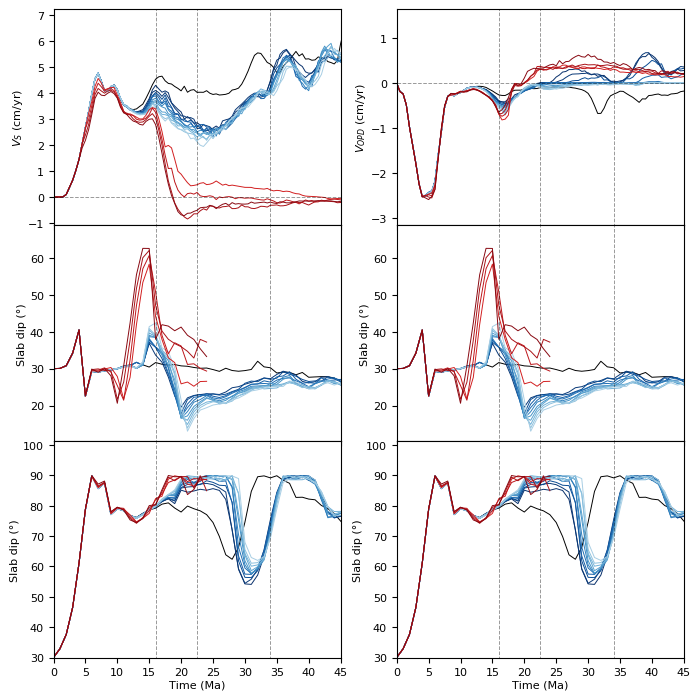

In [64]:
#ThickArray=[0,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
ThickArray=[0,15,16,17,18,19,20,21,22,23,24,25,32,33,34,35]
warnings.filterwarnings('ignore')
ColorsPlots=genStdColorArray(ThickArray,["Blues_r","Reds"],[True, 32.])
Cutdepths=[-80,-300] #Both In kilometers 
fig=plotDipKinematicsAll(ThickArray,Cutdepths,3,25,ColorsPlots,(18/2.54, 18/2.54))
fig

In [65]:
fig.savefig(saveDir+'Fig_8_raw.pdf')

## Short

Using matplotlib backend: agg


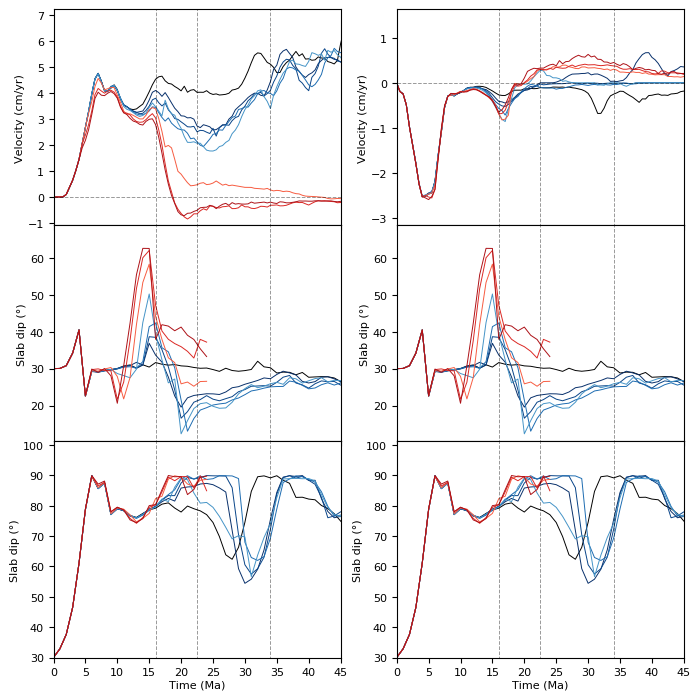

In [51]:
#ThickArray=[0,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
ThickArray=[0,16,20,25,28,32,34,35]
warnings.filterwarnings('ignore')
ColorsPlots=genStdColorArray(ThickArray,["Blues_r","Reds"],[True, 32.])
Cutdepths=[-80,-300] #Both In kilometers 
plotDipKinematicsAll(ThickArray,Cutdepths,3,25,ColorsPlots,(18/2.54, 18/2.54))

The colliding arc promotes the flattening of the subduction zone, and extension in the overriding plate

## Slab-dip shallow (-80 km)

Using matplotlib backend: agg


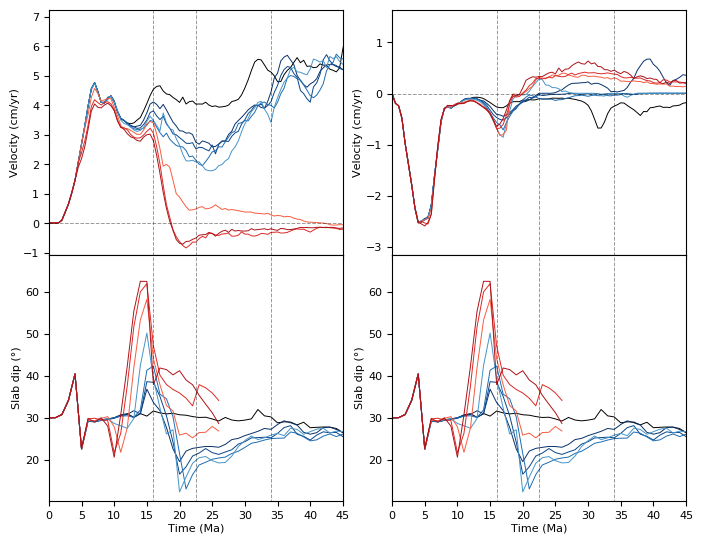

In [48]:
#ThickArray=[0,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
ThickArray=[0,16,20,25,28,32,34,35]
warnings.filterwarnings('ignore')
ColorsPlots=genStdColorArray(ThickArray,["Blues_r","Reds"],[True, 32.])
Cutdepths=[-80] #Both In kilometers 
plotDipKinematicsAll(ThickArray,Cutdepths,3,25,ColorsPlots,(18/2.54, 14/2.54))

## Slab dip - deep (-300 km)

Using matplotlib backend: agg


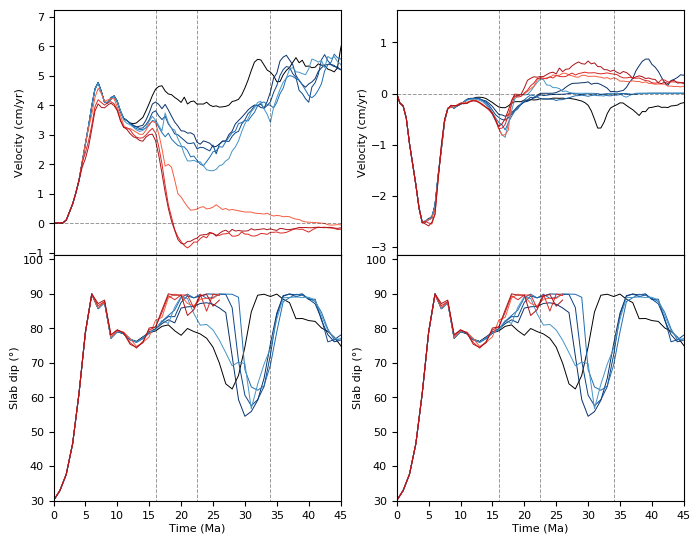

In [49]:
#ThickArray=[0,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
ThickArray=[0,16,20,25,28,32,34,35]
warnings.filterwarnings('ignore')
ColorsPlots=genStdColorArray(ThickArray,["Blues_r","Reds"],[True, 32.])
Cutdepths=[-300] #Both In kilometers 
plotDipKinematicsAll(ThickArray,Cutdepths,3,25,ColorsPlots,(18/2.54, 14/2.54))